# VerseNet

We are gonna make a Recurrent Neural Network to generate fake bible verses

### Loading Data

Using unidecode, we can process the txt into unicode data.

In [1]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

from rnn.model import RNN
from rnn.helpers import time_since

%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

all_characters = string.printable
n_characters = len(all_characters)

file_path = './bible.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4351186
train len:  3916067
test len:  435119


In [2]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

hou art weighed in the balances, and art found wanting.

5:28 PERES; Thy kingdom is divided, and given to the Medes and
Persians.

5:29 Then commanded Belshazzar, and they clothed Daniel with scarlet,



### Input and Target Chunks

Split training data into chunks to feed into the RNN

In [3]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

In [4]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

## Initializing the RNN

First off, we need an evaluation method for the RNN:

In [5]:
def generate_verse(rnn, prime_str='1', temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    count = 0

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    
    while True:
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        
        if predicted_char in numbers and count > 6:
            break
        
        predicted += predicted_char
        inp = char_tensor(predicted_char)
        
        count += 1

    return predicted

Now, we set up so that we can train the RNN:

In [6]:
batch_size = 100
n_epochs = 400
hidden_size = 100
n_layers = 3
learning_rate = 0.01
model_type = 'gru'
print_every = 50
plot_every = 50

def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

This is our central training method:

In [7]:
def train(rnn, inp, target, optimizer, criterion):
    hidden = rnn.init_hidden(batch_size, device=device)
    rnn.zero_grad()
    loss = 0
    for c in range(chunk_len):
        output, hidden = rnn(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    optimizer.step()
    
    return loss

In [8]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 400 epochs...
 33s (50 12%) train loss: 397.8005, test_loss: 2.1113]
 6s (100 25%) train loss: 328.1439, test_loss: 1.8747]
 41s (150 37%) train loss: 291.5684, test_loss: 1.7554]
 14s (200 50%) train loss: 281.5193, test_loss: 1.6644]
 47s (250 62%) train loss: 261.6926, test_loss: 1.5639]
 22s (300 75%) train loss: 261.8075, test_loss: 1.6092]
 56s (350 87%) train loss: 251.7831, test_loss: 1.4691]
 30s (400 100%) train loss: 250.6815, test_loss: 1.5455]


## Network Analysis
Now that we have run our network, we will plot the loss and exaluate it on a starting prompt:

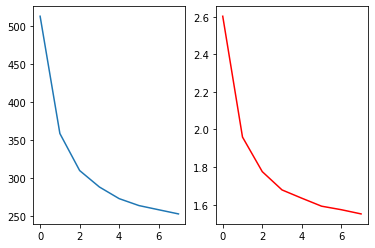

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.plot(all_losses)
ax2.plot(test_losses, color='r')

In [10]:
from random import randint

for i in range(5):
    chapter = randint(1, 9)
    verse = randint(1, 9)
    
    print(generate_verse(rnn, str(chapter) + ':' + str(verse)))

6:5 And it shall not man his fathers, and fall she should I have done shall how myself.


2:14 And the LORD is with my strengthen in Samariah, and
him that sEckove and in them, bere was the God of Israel, which was wcords are preveepents all of the tribe earning.


4:5 And poslou the LORD toward he should put the king, and the father was and named out of the possesser; he lined against him, and things of the
sons of Zia, Peried the house of the sight of the house of the king that spoken shall be than hath said unto the balone,
and thee this sacrifice, that the rebellious was any of the
horserour said unto their land, and the sight that lay shall returned the way, which for this hand of the kings
of thy son of Za, 
3:3 And the neight had in the nations of God toward him light thy holle, and called all him.


9:12
I have given a ead the fourth gace with me, and reby shut unto him?  


## Sources

UIUC CS498DL

https://raw.githubusercontent.com/mxw/grmr/master/src/finaltests/bible.txt